# Energy Dependance w/out a dependance on the current NPTFit framework. 

This is a tool used to create a liklyhood function. In order to minimise confusion from the complexity of the NPTFit code, this code will use MC data (photon number and energy) and Multinest to test and create the likelihood function which will be used for the NPTFit analysis package. The desired liklihood funtion will include energy dependance and work on non-poissonian data. 

This code will begin with the simple case of poissonian statistics for both phton number and energy of the photons. 


The desired modules are imported. 

In [67]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from math import *

from NPTFit import nptfit # module for performing scan
from NPTFit import dnds_analysis # module for analysing the output
from matplotlib import pyplot as plt # to see plots
import scipy.stats as stats
import matplotlib.pyplot as plt

import pymultinest

## Making Data

Energy follows a smooth power law. Ben uses broken power laws to explain the location of phtons 


In [68]:
def truncated_power_law(a, m):
    E = np.arange(1, m+1,dtype='float') #array of energy values
    pmf = 1/E**a                        #math with arrays like numbers, thanks python!
    pmf /= pmf.sum()                    #normalizes the distribution
    return stats.rv_discrete(values=(range(1, m+1), pmf)) #80/20.. this goes in the 20. keep er movin. 


Spectral Coefficients are those which give weight to energy bins and are defined as follows: The $i^{th}$ specral coefficient for the $i^{th}$ energy bin is:

$$\lambda _i = \int _ i \frac{dN}{dE} dE$$ such that $\frac{dN}{dE} = E^{-\alpha}$



In [69]:
def get_spectral_coefficients(a,m):
	d = truncated_power_law(a,m)#output 
	
	N = 10**4
	sample = d.rvs(size=N)  #is an array of the randomly generated values

	bins = np.arange(m)+0.5   #there will be as many bins as energy values ....+0.5 keep er movin
	hist1, _, _ = plt.hist(sample, bins, normed=True)
	plt.title('Photon Energy Distribution')

	first_spectral_coeff = sum(hist1[0:(len(bins)-1)/2])
	second_spectral_coeff = sum(hist1[(len(bins)-1)/2:len(bins)-1])

	return first_spectral_coeff, second_spectral_coeff


The break of the power law occurs at m, and the exponent is a

first spectral coefficient =  0.591591185616
second spectral coefficient =  0.408408814384


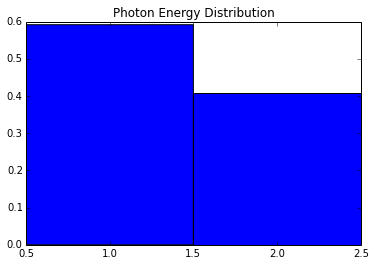

In [70]:
a, m = .5, 3 #method for distributing energy data into two bins. found online. where? i dunno either
first_spectral_coeff, second_spectral_coeff = get_spectral_coefficients(a,m)
print('first spectral coefficient = ', first_spectral_coeff)
print('second spectral coefficient = ', second_spectral_coeff)


Number of exposure regions set. Useful for....


In [71]:
nside = 2
npix = hp.nside2npix(nside)

Poissonian data for the number of photons in each bin

In [72]:
data = np.random.poisson(1,npix)

Split the data up into energy bins, and find max count

In [73]:
data_bin1 = data*first_spectral_coeff  #number of photons in the first energy bin according to the power law
data_bin2 = data*second_spectral_coeff #number of photons in the second energy bin according to the power law
exposure = np.ones(npix)
max_counts = np.amax(data)

#Note: Fractional number of photons, maybe non physical?

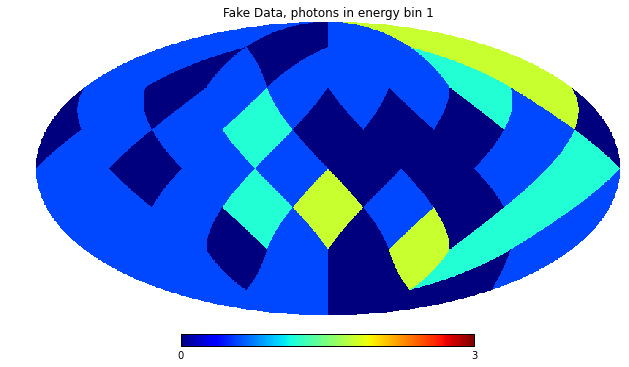

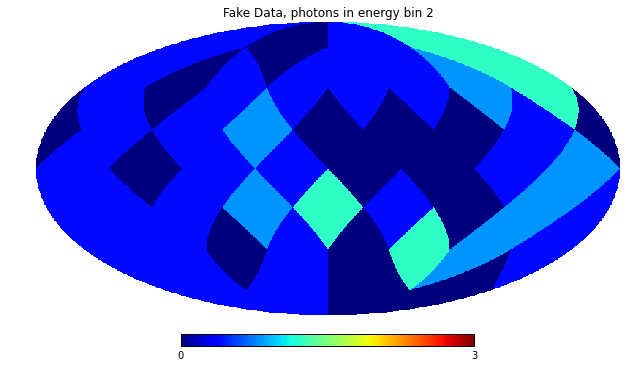

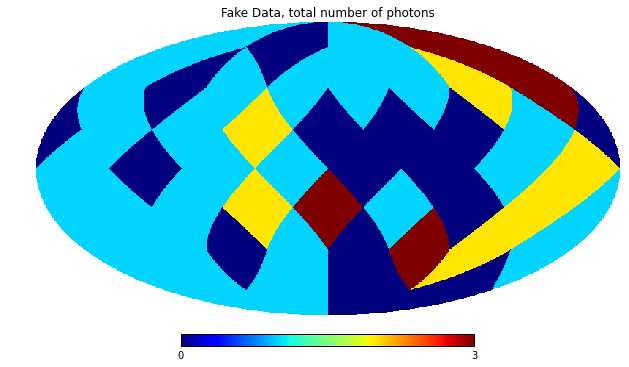

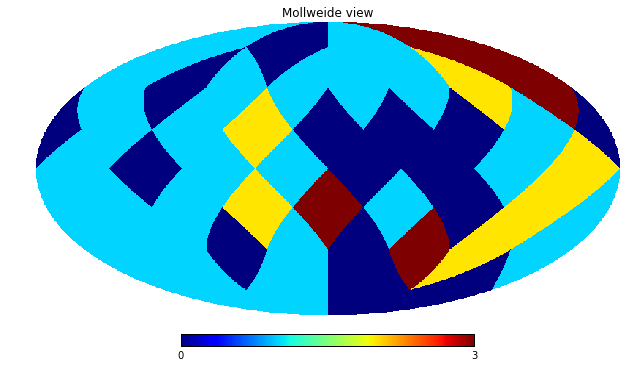

In [74]:
#fig1, (ax1, ax2) = plt.subplots(ncols=2)

#plt.axes(ax1)

hp.mollview(data_bin1, title="Fake Data, photons in energy bin 1", min=0, max=max_counts)
hp.mollview(data_bin2, title='Fake Data, photons in energy bin 2', min=0, max=max_counts)
hp.mollview(data, title='Fake Data, total number of photons', min=0, max=max_counts)
hp.mollview(data_bin1 + data_bin2, 'Fake Data, photons in energy bin 1 + photons in energy bin 2', min=0, max=max_counts)


## Log Likelyhood


First we make some definitions for convience. 

Mean is an array of the mean number of photons counts in pixel p, it is the usual poissonian parameter.


energy_data is the number of photons in each pixel in each bin of energy, it is a 2D array
[pixels,energy bins] so energy_data[3,1] is the number of counts in the 4th pixel and 2nd energy bin

In [75]:
energy_data = [data_bin1, data_bin2] 
parameters = ["mean","spectral_0","spectral_1"] #mean is an array of the mean number of photons counts in pixel p, it is the usual poissonian parameter
n_params = len(parameters)
theta_interval = [[0,2],[0.0,1.0],[0.0,1.0]]

Define Loglikelyhood function

In [76]:
def loglike(cube, ndim, nparams):

    ll = 0

    for p in range(0,len(energy_data[0])):
        #print('pixel ', p)
        ll += -cube[0] + data[p]*np.log(cube[0]) - lgamma(data[p] + 1.) #comes from cython and cython doesn't work
        for s in range(0,nparams -1): #the first position in theta is the mean, so need not be considered
            #print('energy bin ', s)
            #print('content of bin = ',energy_data[s][p] )
            ll += energy_data[s][p]*cube[s+1]#similarly, the zeroth position is mean - not a specral coeff. 

    return ll

## Analysing w/ Multinest  

Multinest requires numerical bounds for analysis, these are extracted from the data in the following way


In [77]:
def min_and_diff(theta_interval):
    min_theta_interval = []
    diff_theta_interval = []
    
    for i in theta_interval:
        min_theta_interval.append(i[0])

        diff_theta_interval.append(i[1] - i[0])

    return min_theta_interval, diff_theta_interval


min_theta_interval, diff_theta_interval = min_and_diff(theta_interval)

In [78]:
######## from 165 in nptf_scan
def prior_cube(cube, ndim=1, nparams=1):
    """ Cube of priors; motivated by format required by MultiNest, but can
            be used for different MCMC evaluators
    """
    for i in range(ndim):
        cube[i] = cube[i] * diff_theta_interval[i] + min_theta_interval[i]
    return cube
########

In [79]:
pymultinest_options = {'importance_nested_sampling': False,
                                   'resume': False, 'verbose': True,
                                   'sampling_efficiency': 'model',
                                   'init_MPI': False, 'evidence_tolerance': 0.5,
                                   'const_efficiency_mode': False}

nlive = 500

Running Multinest!

In [80]:
pymultinest.run(loglike, prior_cube, n_params, outputfiles_basename='/Users/test/NTPFit/EdepSimple_output/',n_live_points=nlive, **pymultinest_options)

a = pymultinest.Analyzer(outputfiles_basename='/Users/test/NTPFit/EdepSimple_output/', n_params = n_params)
s = a.get_stats()

  analysing data from /Users/test/NTPFit/EdepSimple_output/.txt


In [81]:
best_fit_params = a.get_best_fit() 

print('The medians for our parameters are: ', best_fit_params)

The medians for our parameters are:  {u'log_likelihood': -11.39667490250536, u'parameters': [1.0515666672684385, 0.9998680434859939, 0.99972962117044495]}
